# Проект для «Викишоп» c BERT

Цель проекта:
- Разработать модель машинного обучения, которая будет автоматически определять токсичные комментарии, чтобы направлять их на модерацию.
Требуется добиться качества F1 >= 0.75 на тестовой выборке.

Ход работы (через BERT):
1. Загрузка и анализ данных
- Загрузить датасет;
- Изучить текстовые данные и целевой признак toxic.
2. Токенизация:
- Использовать токенизатор BertTokenizer;
- Преобразовать тексты в токены;
- Ограничить длину последовательностей;
- Применить padding и создать attention_mask.
3. Построение эмбеддингов:
- Пропустить токенизированные батчи через модель BERT;
- Извлечь эмбеддинг как представление текста.
4. Формирование выборок:
- Взять случайную подвыборку;
- Разделить на обучающую и тестовую части.
5. Обучение классификатора:
- Обучить LogisticRegression и другие модели на эмбеддингах;
- Настроить параметры.
6. Оценка качества:
- Предсказать метки на тестовой выборке;
- Вычислить F1-score и проверить, что он не ниже 0.75.
7. Выводы

In [1]:
!pip install numpy pandas transformers scikit-learn catboost seaborn -q

In [2]:
!pip install seaborn --q

In [3]:
!pip install catboost -q

In [4]:
conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia -q

Jupyter detected...
Channels:
 - pytorch
 - nvidia
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
# импорт необходимых биюлиотек
import os

import numpy as np
import pandas as pd
import torch
import nltk
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from tqdm import notebook
from transformers import BertConfig, BertModel, BertTokenizer

In [6]:
# задаем константы
RANDOM_STATE = 12345
batch_size = 200

In [7]:
# проверка гпу
print("CUDA доступна:", torch.cuda.is_available())
print("Имя устройства:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "нет GPU")
print(torch.cuda.get_device_name(0)) 

CUDA доступна: True
Имя устройства: NVIDIA GeForce RTX 2070
NVIDIA GeForce RTX 2070


## загрузка и анализ таблицы

In [8]:
# Список возможных путей
paths = [
    '/Users/nastyadukhina/Downloads/toxic_comments.csv',
    '/datasets/toxic_comments.csv',
    r'C:\Users\zhili\Downloads\Telegram Desktop\toxic_comments.csv'
]

# Ищем существующий путь
for path in paths:
    if os.path.exists(path):
        print(f'Файл найден по пути: {path}')
        df = pd.read_csv(path, index_col=0)      
        break
    else:
        print('Файл не найден ни по одному из путей.')

display(df.head())

Файл не найден ни по одному из путей.
Файл не найден ни по одному из путей.
Файл найден по пути: C:\Users\zhili\Downloads\Telegram Desktop\toxic_comments.csv


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
# вывод основной информации о датафрейме
display(df.info())
display(df.shape)
display(df.isnull().sum())
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

(159292, 2)

text     0
toxic    0
dtype: int64

np.int64(0)

в датасете содержится 2 столбца и около 160 000 строк. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

пропуски и дубликаты отсутствуют

C:\Users\zhili\AppData\Local\Temp\ipykernel_8120\2243167355.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['toxic'].value_counts().index, y=df['toxic'].value_counts().values, palette='pastel')


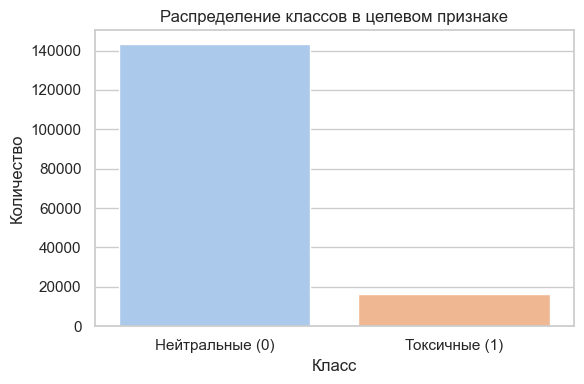

In [10]:
# визуализируем распределение классов в целевом признаке
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=df['toxic'].value_counts().index, y=df['toxic'].value_counts().values, palette='pastel')

plt.xticks([0, 1], ['Нейтральные (0)', 'Токсичные (1)'])
plt.title('Распределение классов в целевом признаке')
plt.ylabel('Количество')
plt.xlabel('Класс')
plt.tight_layout()
plt.show()

Токсичных твитов в 8 раз меньше чем нейтральных

In [11]:
# Количество слов в тексте
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

# Средняя длина слова
df['avg_word_len'] = df['text'].astype(str).apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
)

# Группировка по целевому признаку
df.groupby('toxic')[['word_count', 'avg_word_len']].agg(['mean', 'median'])

word_count        avg_word_len          
            mean median         mean    median
toxic                                         
0      68.857665   37.0     4.910278  4.714286
1      52.677314   23.0     5.168201  4.487652

можно сделать вывод, что в токсичных твитах, как правило, меньше слов, чем в нейтральных.

Количество слов в предложении не сильно отличается в обеих группах

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zhili\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\zhili\AppData\Local\Temp\ipykernel_8120\2685138475.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='toxic', y='sentiment', palette='Set2')


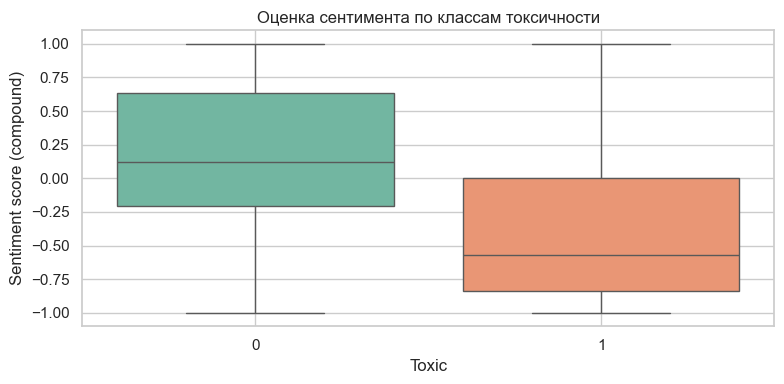

Корреляция сентимента с токсичностью: -0.295


In [12]:
# проведем анализ тональности твитов в разбивке по целевому признаку с помощью оценки сантиментов

# загрузим лексикон VADER 
nltk.download('vader_lexicon')

# Инициализируем анализатор тональности VADER
sia = SentimentIntensityAnalyzer()

# вычисляем полярность текста.  compound: метрика, которая вычисляет сумму всех оценок лексики,
# нормализованных между −1 (крайне отрицательное) и +1 (крайне положительное).
df['sentiment'] = df['text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# построение боксплота
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='toxic', y='sentiment', palette='Set2')
plt.title('Оценка сентимента по классам токсичности')
plt.xlabel('Toxic')
plt.ylabel('Sentiment score (compound)')
plt.grid(True)  
plt.tight_layout()
plt.show()          

# расчёт корреляции между сентиментом и токсичностью
correlation = df[['sentiment', 'toxic']].corr().iloc[0, 1]
print(f"Корреляция сентимента с токсичностью: {correlation:.3f}")           

разброс оценок лексики нейтральных твитов сосредоточен в основном в диапазоне выше нуля, в то время как негативные твиты имеют мелианную оценку тональности около -60.

отрицательная корреляция говорит о том, что чем ниже оценка сантиментов, тем выше вероятность токсичности

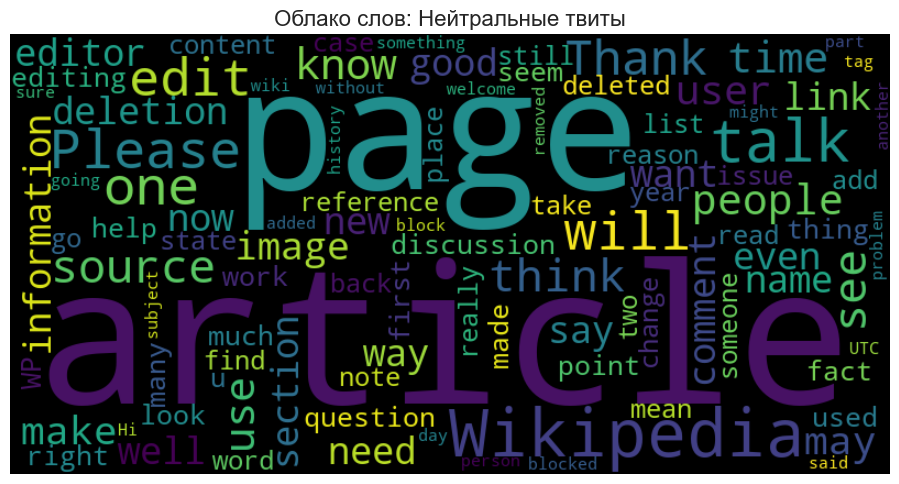

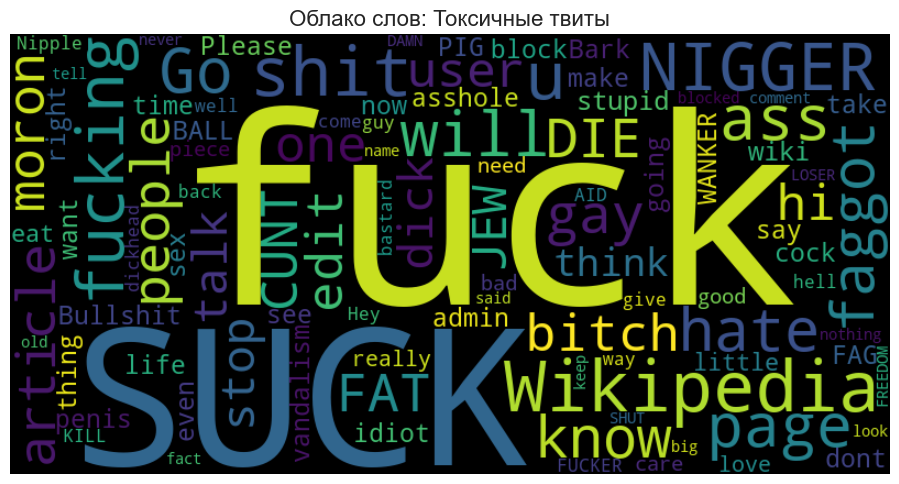

In [13]:
# Разделим тексты по классам
text_neutral = ' '.join(df[df['toxic'] == 0]['text'].dropna().astype(str))
text_toxic = ' '.join(df[df['toxic'] == 1]['text'].dropna().astype(str))        

# Функция отрисовки облака
def show_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          max_words=100, collocations=False).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# Отрисуем оба
show_wordcloud(text_neutral, 'Облако слов: Нейтральные твиты')
show_wordcloud(text_toxic, 'Облако слов: Токсичные твиты')

Наиболее популярными словами в твитах с нейтральной лексикой являются: article, page, wikipedia. Следовательно, этот контент можно отнести к образовательному сегменту.

fuck, suck, nigger и другие матерные слова встречаются чаще остальных в токсичных твитах.

выводы:

в исходном датасете содержится 159 292 твитов без пропусков и дубликатов. примерно 90% из них — нейтральные, и только около 10% — токсичные, что создаёт значительный дисбаланс классов. Это может мешать качественному обучению моделей, особенно при использовании метрики F1.

мы обнаружили, что в токсичных твитах, как правило, меньше слов, чем в нейтральных и создали столбец с нормализованной оценкой лексики от 1 до -1, который можно будет использовать при обучении моделей. Кроме того токсичные твиты выделяются на фоне остальных благодаря обсценной лексике.

## векторизация текстов и подготовка эмбеддингов

Загружаем токенизатор от модели  toxic-bert, который умеет разбивать текст на токены. ограничиваем максимальную длину текстов числом 256, если сообщение меньше - то к нему будут добавлены нули, а если длиннее - то оно будет обрезано

In [14]:
# Готовим данные
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

C:\Users\zhili\anaconda3\envs\rubert-gpu\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zhili\.cache\huggingface\hub\models--unitary--toxic-bert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
# Применяем токенизатор ко всем текстам
encoding = tokenizer(
    list(df['text']),
    padding=True,  # выравниваем тексты по длине
    truncation=True, # обрезаем длинные тексты
    max_length=256, # максимальная длина текста
    return_tensors='pt' # возвращаем данные в формате тензоров PyTorch
)

In [16]:
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask'] # маска, где 1 — это реальные токены, 0 — паддинг

In [17]:
# Выбор устройства: GPU если доступно, иначе через CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

Используемое устройство: cuda


In [19]:
#  Загружаем предобученную модель toxic-bert
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert',
    trust_remote_code=True,
    use_safetensors=True) # безопасная загрузка

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [20]:
# переносим модель на выбранное устройство
model.to(device) 
model.eval()  # отключаем dropout и другие случайности

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [21]:
# Переносим данные на устройство
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

In [22]:
# Обработка батчами
embeddings = [] 

for i in notebook.tqdm(range(0, len(input_ids), batch_size)):  # запускаем цикл с прогрессбаром
    batch_input_ids = input_ids[i:i+batch_size]
    batch_attention_mask = attention_mask[i:i+batch_size]  # вырезаем очередной батч из входных тензоров

    with torch.no_grad(): # вызываем модель без градиентов
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)

    cls_batch = outputs.last_hidden_state[:, 0, :]  # CLS токен
    embeddings.append(cls_batch.cpu().numpy())  # переносим обратно на CPU перед объединением

  0%|          | 0/797 [00:00<?, ?it/s]

In [24]:
# Объединяем все векторы
features = np.concatenate(embeddings)
# собираем все батчи в один массив признаков 

выводы:

для извлечения векторных представлений текстов использовалась предобученная модель  toxic-bert. она была загружена на GPU, переведена в режим вывода, и тексты были обработаны в виде батчей с применением масок внимания. в качестве эмбеддингов использовались векторы CLS-токенов, что позволило получить обобщённую характеристику каждого текста. полученные векторы впоследствии были объединены в общий массив признаков, подходящий для подачи в модели. подготовка прошла успешно и данные готовы к этапу классификации.

## обучение моделей

In [25]:
# Целевая переменная
y = df['toxic'].values  

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    features,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE  
)

итоговый размер выборок:
- обучающая - 80%
- тестовая - 20%

In [26]:
# сохраним эмбеддинги в файл
np.save('bert_features.npy', features)
np.save('labels.npy', y)

In [27]:
features = np.load('bert_features.npy')
y = np.load('labels.npy')

In [28]:
# разделим данные на 5 фолдов 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [29]:
# Логистическая регрессия

lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Инициализируем модель
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Перебираем случайные 5 сочетаний параметров из lr_params
grid_lr = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_params,
    n_iter=5,
    cv=cv,
    scoring='f1',
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучение
grid_lr.fit(X_train, y_train)
print(f"\nLogReg лучшие параметры: {grid_lr.best_params_}")

cv_mean_f1 = grid_lr.best_score_
print(f"Средняя F1 по 5 фолдам: {cv_mean_f1:.3f}")

C:\Users\zhili\anaconda3\envs\rubert-gpu\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits

LogReg лучшие параметры: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
Средняя F1 по 5 фолдам: 0.947


In [31]:
# Случайный лес

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Инициализируем модель
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

grid_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    n_iter=5,
    cv=cv,
    scoring='f1',
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучение
grid_rf.fit(X_train, y_train)
print(f"\nRandomForest лучшие параметры: {grid_rf.best_params_}")

cv_mean_f1_rf = grid_rf.cv_results_['mean_test_score'][grid_rf.best_index_]
print(f"Средняя F1 по 5 фолдам: {cv_mean_f1_rf:.3f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits

RandomForest лучшие параметры: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10}
Средняя F1 по 5 фолдам: 0.944


In [35]:
# CatBoost

# Параметры для подбора
catboost_params = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Инициализируем модель
cb_model = CatBoostClassifier(
    verbose=0,
    task_type="GPU", 
    devices='0',
    random_state=RANDOM_STATE
)

# RandomizedSearchCV
grid_cb = RandomizedSearchCV(
    estimator=cb_model,
    param_distributions=catboost_params,
    n_iter=5,
    cv=cv,
    scoring='f1',
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=1  
)

# Обучение
grid_cb.fit(X_train, y_train)
print(f"\nЛучшие параметры CatBoost: {grid_cb.best_params_}")

cv_mean_f1_cb = grid_cb.cv_results_['mean_test_score'][grid_cb.best_index_]
print(f"Средняя F1 по 5 фолдам: {cv_mean_f1_cb:.3f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits



Лучшие параметры CatBoost: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 6}
Средняя F1 по 5 фолдам: 0.945


In [33]:
# Предсказание и оценка лучшей модели на тестовой выборке
best_model = grid_lr.best_estimator_
y_pred_lr = best_model.predict(X_test)
print(f"F1 LogReg: {f1_score(y_test, y_pred_lr):.3f}")

F1 LogReg: 0.950


выводы:

наилучшее значение метрики  на кросс-валидации показала модель логистической регрессии (F1-score = 0.947), на втором месте градиентный бустинг (F1-score = 0.945). Очень долго училась и чуть хуже справилась модель RandomForest (F1-score = 0.944). Однако все три модели показали отличный результат (выше 0.9)



на тестовой выборке логистическая регрессия показала точность еще выше (F1-score = 0.950), однако достаточно близкую к резульату при кросс-валидации, а следовательно нам удалось избежать переобучения и недообучения модели.

## выводы

для получения эмбеддингов твитов была использована модель Toxic BERT. Тексты были токенизированы, обработаны в батчах и преобразованы в векторы. модель была загружена на GPU и переведена в режим вывода, чтобы исключить случайности и ускорить извлечение признаков.

на этапе обучения были протестированы модели логистической регрессии, случайного леса и градиентного бустинга. Оценка производилась по метрике F1 с использованием кросс-валидации и RandomizedSearchCV. все три модели превысили требуемый порог в 0.75 и показали высокое качество классификации.